In [ ]:
!pip install catboost

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from catboost import CatBoostClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.metrics import roc_auc_score, roc_curve

In [ ]:
data = pd.read_csv('/kaggle/input/advanced-dls-spring-2021/train.csv')
data_test = pd.read_csv('/kaggle/input/advanced-dls-spring-2021/test.csv')
submission = pd.read_csv('/kaggle/input/advanced-dls-spring-2021/submission.csv')

In [ ]:
data.sample(5)

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
4156,67,19.65,1335.2,Female,0,Yes,No,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,0
5109,24,75.40,1747.85,Female,0,Yes,No,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Credit card (automatic),1
349,8,25.50,215.2,Male,0,No,Yes,No,No phone service,DSL,No,No,No,No,No,No,Month-to-month,No,Mailed check,1
4566,28,106.10,2847.4,Male,0,Yes,Yes,Yes,Yes,Fiber optic,Yes,Yes,No,No,Yes,Yes,One year,No,Electronic check,1
3,32,79.30,2570,Female,1,Yes,No,Yes,Yes,Fiber optic,No,No,Yes,No,No,No,Month-to-month,No,Mailed check,0


In [ ]:
# Для вашего удобства списки с именами разных колонок

# Числовые признаки
num_cols = [
    'ClientPeriod',
    'MonthlySpending',
    'TotalSpent'
]

# Категориальные признаки
cat_cols = [
    'Sex',
    'IsSeniorCitizen',
    'HasPartner',
    'HasChild',
    'HasPhoneService',
    'HasMultiplePhoneNumbers',
    'HasInternetService',
    'HasOnlineSecurityService',
    'HasOnlineBackup',
    'HasDeviceProtection',
    'HasTechSupportAccess',
    'HasOnlineTV',
    'HasMovieSubscription',
    'HasContractPhone',
    'IsBillingPaperless',
    'PaymentMethod'
]

feature_cols = num_cols + cat_cols
target_col = 'Churn'

In [ ]:
data_test.isna().sum().reset_index()

,index,0
0,ClientPeriod,0
1,MonthlySpending,0
2,TotalSpent,0
3,Sex,0
4,IsSeniorCitizen,0
5,HasPartner,0
6,HasChild,0
7,HasPhoneService,0
8,HasMultiplePhoneNumbers,0
9,HasInternetService,0


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5282 entries, 0 to 5281
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ClientPeriod              5282 non-null   int64  
 1   MonthlySpending           5282 non-null   float64
 2   TotalSpent                5282 non-null   object 
 3   Sex                       5282 non-null   object 
 4   IsSeniorCitizen           5282 non-null   int64  
 5   HasPartner                5282 non-null   object 
 6   HasChild                  5282 non-null   object 
 7   HasPhoneService           5282 non-null   object 
 8   HasMultiplePhoneNumbers   5282 non-null   object 
 9   HasInternetService        5282 non-null   object 
 10  HasOnlineSecurityService  5282 non-null   object 
 11  HasOnlineBackup           5282 non-null   object 
 12  HasDeviceProtection       5282 non-null   object 
 13  HasTechSupportAccess      5282 non-null   object 
 14  HasOnlin

In [ ]:
data = data.replace(' ', np.nan)
data_test = data_test.replace(' ', np.nan)
data = data.replace(np.nan, 0)

missing_values_table = data.isna().sum().reset_index()
missing_values_table.columns = ['Column', 'Missing Values']
missing_values_table['% of Total Values'] = (missing_values_table['Missing Values'] / len(data)) * 100


missing_values_table

,Column,Missing Values,% of Total Values
0,ClientPeriod,0,0.0
1,MonthlySpending,0,0.0
2,TotalSpent,0,0.0
3,Sex,0,0.0
4,IsSeniorCitizen,0,0.0
5,HasPartner,0,0.0
6,HasChild,0,0.0
7,HasPhoneService,0,0.0
8,HasMultiplePhoneNumbers,0,0.0
9,HasInternetService,0,0.0


In [ ]:
for col in num_cols:
    data[col] = pd.to_numeric(data[col], errors='coerce')

data.isna().sum().reset_index()

,index,0
0,ClientPeriod,0
1,MonthlySpending,0
2,TotalSpent,0
3,Sex,0
4,IsSeniorCitizen,0
5,HasPartner,0
6,HasChild,0
7,HasPhoneService,0
8,HasMultiplePhoneNumbers,0
9,HasInternetService,0


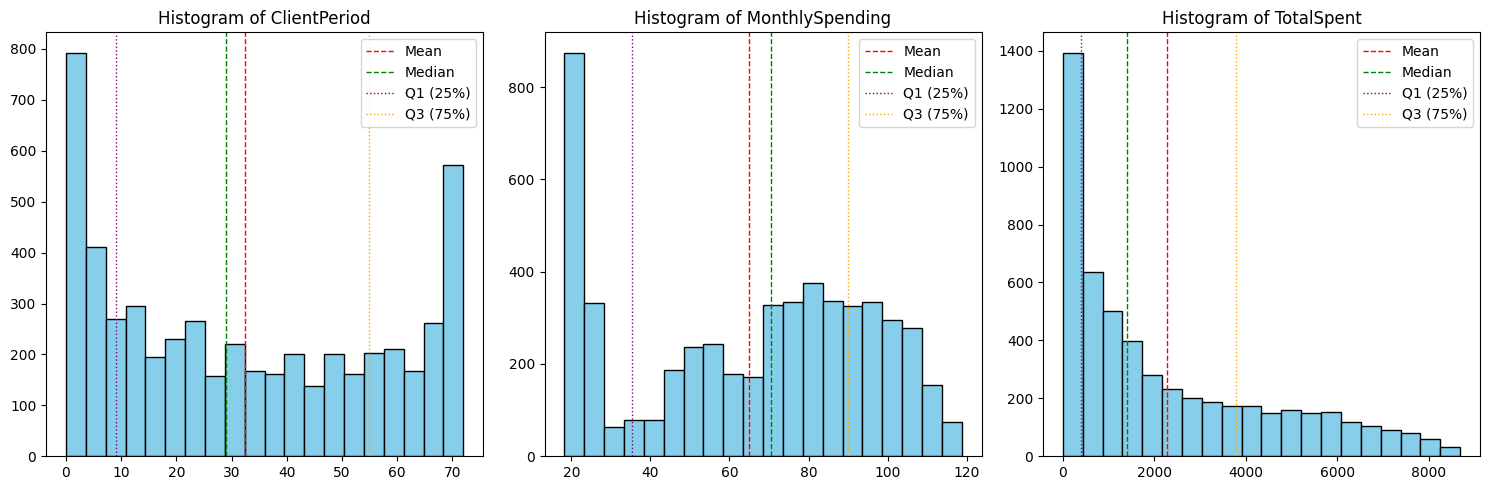

In [ ]:
plt.figure(figsize=(15, 5))

for i, col in enumerate(num_cols, 1):
    plt.subplot(1, len(num_cols), i)
    plt.hist(data[col], bins=20, color='skyblue', edgecolor='black')

    mean_val = data[col].mean()
    median_val = data[col].median()
    q1 = data[col].quantile(0.25)
    q3 = data[col].quantile(0.75)

    plt.axvline(mean_val, color='red', linestyle='--', linewidth=1, label='Mean')
    plt.axvline(median_val, color='green', linestyle='--', linewidth=1, label='Median')
    plt.axvline(q1, color='purple', linestyle=':', linewidth=1, label='Q1 (25%)')
    plt.axvline(q3, color='orange', linestyle=':', linewidth=1, label='Q3 (75%)')

    plt.title(f'Histogram of {col}')
    plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
X = data[feature_cols]
X_test = data_test[feature_cols]

y = data[target_col]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Размерности после обработки:")
print("X_train:", X_train.shape)
print("X_valid:", X_test.shape)
print("y_train:", y_train.shape)
print("y_valid:", y_test.shape)

Размерности после обработки:
X_train: (4225, 19)
X_valid: (1057, 19)
y_train: (4225,)
y_valid: (1057,)


In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(drop='first'), cat_cols)
    ]
)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(solver='liblinear'))
])

param_grid = {
    'classifier__C': [100, 10, 1, 0.1, 0.01, 0.001]
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='roc_auc', n_jobs=-1, verbose=1)

grid_search.fit(X_train, y_train)

print("Оптимальное значение параметра C:", grid_search.best_params_['classifier__C'])
print("Лучший ROC-AUC на train:", grid_search.best_score_)

y_train_pred = grid_search.predict_proba(X_train)[:, 1]
y_pred_proba = grid_search.predict_proba(X_test)[:, 1]

# Вычисление ROC-AUC
train_auc = roc_auc_score(y_train, y_train_pred)
test_auc = roc_auc_score(y_test, y_pred_proba)

print("ROC-AUC на test:", roc_auc)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Оптимальное значение параметра C: 10
Лучший ROC-AUC на train: 0.8488522938882642
ROC-AUC на test: 0.827906096175691


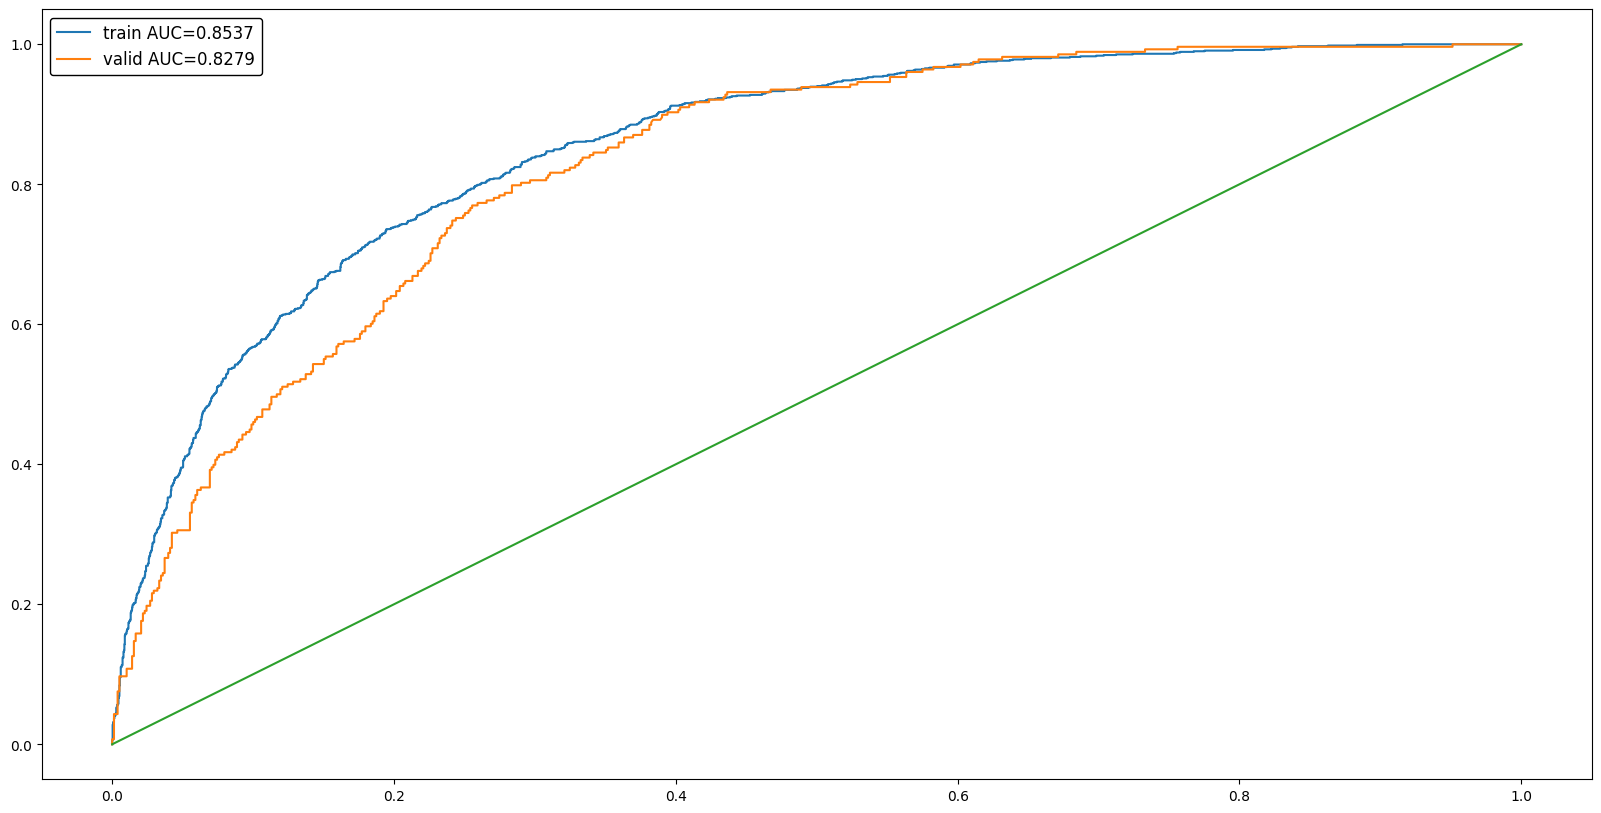

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(*roc_curve(y_train, y_train_pred)[:2], label='train AUC={:.4f}'.format(train_auc))
plt.plot(*roc_curve(y_test, y_pred_proba)[:2], label='valid AUC={:.4f}'.format(test_auc))
legend_box = plt.legend(fontsize='large', framealpha=1).get_frame()
legend_box.set_facecolor("white")
legend_box.set_edgecolor("black")
plt.plot(np.linspace(0,1,100), np.linspace(0,1,100))
plt.show()

In [ ]:
boosting_model = CatBoostClassifier(n_estimators=200,
                                    cat_features=cat_cols,
                                    bootstrap_type = 'Bayesian',
                                    eval_metric='AUC',
                                    verbose=False)

grid_search_result = boosting_model.grid_search(
    {'l2_leaf_reg': [0.01, 0.5, 1, 1.5],
     'learning_rate': [0.01, 0.05, 0.1, 0.3, 1]},
    X_train,
    y_train,
    plot=True,
    refit=True,
    cv=10
)
boosting_model.fit(X_train, y_train)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


bestTest = 0.8317553773
bestIteration = 199

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
0:	loss: 0.8317554	best: 0.8317554 (0)	total: 2.81s	remaining: 53.4s

bestTest = 0.8310832183
bestIteration = 72

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
1:	loss: 0.8310832	best: 0.8317554 (0)	total: 5.04s	remaining: 45.3s

bestTest = 0.830083966
bestIteration = 27

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
2:	loss: 0.8300840	best: 0.8317554 (0)	total: 7.3s	remaining: 41.4s

bestTest = 0.8273881412
bestIteration = 16

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
3:	loss: 0.8273881	best: 0.8317554 (0)	total: 9.69s	remaining: 38.7s

bestTest

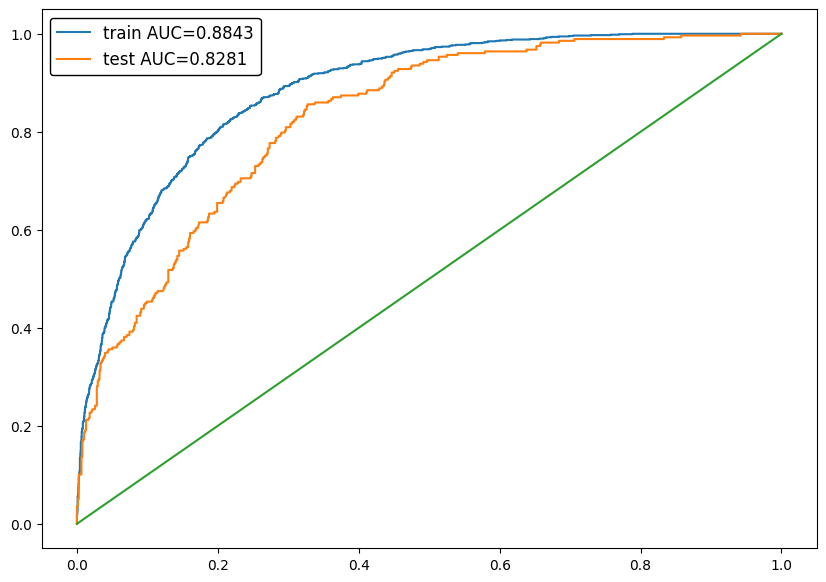

In [ ]:
y_train_predicted2 = boosting_model.predict_proba(X_train)[:, 1]
y_valid_predicted2 = boosting_model.predict_proba(X_test)[:, 1]
train_auc2 = roc_auc_score(y_train, y_train_predicted2)
valid_auc2 = roc_auc_score(y_test, y_valid_predicted2)
plt.figure(figsize=(10,7))
plt.plot(*roc_curve(y_train, y_train_predicted2)[:2], label='train AUC={:.4f}'.format(train_auc2))
plt.plot(*roc_curve(y_test, y_valid_predicted2)[:2], label='test AUC={:.4f}'.format(valid_auc2))
legend_box = plt.legend(fontsize='large', framealpha=1).get_frame()
legend_box.set_facecolor("white")
legend_box.set_edgecolor("black")
plt.plot(np.linspace(0,1,100), np.linspace(0,1,100))
plt.show()

In [ ]:
best_model = boosting_model
submission['Churn'] = best_model.predict_proba(data_test)[:,1]
submission.to_csv('./my_submission.csv')